# <font color='blue'>Imports </font>

In [12]:
%%time
import pandas as pd
import os
import seaborn as sns
import lightgbm
import optuna
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, log_loss, brier_score_loss, f1_score

Wall time: 0 ns


In [15]:
%%time
path = "{}\\{}\\{}\\{}\\".format(os.getcwd(), "webscrapping", "matches", "rounds")
filename = "combined_br.csv"
dataset = pd.read_csv('{}{}'.format(path, filename))

D:\Python\Classification_datascience
Wall time: 29.9 ms


In [16]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner'],
      dtype='object')

In [17]:
dataset.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,DEF_duelists,DEF_sentinels,DEF_controllers,ATK_Shields,DEF_Shields,MapName,MatchID,SeriesID,bestOF,FinalWinner
0,400134,1,0,1000,2000,5,5,0,0,0,...,0,2,2,75,25,Haven,25345,12615,3,0
1,400134,1,19563,1000,2000,4,5,0,0,20,...,0,2,2,50,25,Haven,25345,12615,3,0
2,400134,1,20622,1000,1500,4,4,0,0,21,...,0,1,2,50,25,Haven,25345,12615,3,0
3,400134,1,21058,1000,1500,3,4,0,0,21,...,0,1,2,50,25,Haven,25345,12615,3,0
4,400134,1,22900,500,1500,2,4,0,0,23,...,0,1,2,25,25,Haven,25345,12615,3,0


# <font color='blue'> Predict variable </font>

In [18]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                     'ATK_Shields', 'DEF_Shields',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [6]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [7]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,2500,0,1,2,1,1,1,1,2,1,...,0,0,0,0,0,0,0,1,0,0
1,2500,0,1,2,1,1,1,0,2,1,...,0,21,0,0,0,0,0,1,0,0
2,2000,0,1,1,1,1,1,0,2,1,...,0,22,0,0,0,0,0,1,0,0
3,1500,0,1,0,1,1,1,0,2,1,...,0,24,0,0,0,0,0,1,0,0
4,1000,0,0,0,1,1,1,0,2,1,...,0,26,0,0,0,0,0,1,0,0


# <font color='blue'>Parameter tuning </font>

In [8]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [9]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-06-24 18:41:38,049] A new study created in memory with name: no-name-88927173-4646-48cd-b177-64c9f99a9dd2


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-24 18:41:38,629] Trial 0 finished with value: 0.15955804985888028 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 10, 'max_depth': 5, 'learning_rate': 0.011302669426946311, 'num_leaves': 10, 'num_threads': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.15955804985888028.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-24 18:41:40,081] Trial 1 finished with value: 0.14194760912395607 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 38, 'max_depth': 15, 'learning_rate': 0.015702444090087683, 'num_leaves': 49, 'num_threads': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 1 with value: 0.14194760912395607.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-24 18:41:40,879] Trial 2 finished with value: 0.13073736478666753 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 53, 'max_depth': 13, 'learning_rate': 0.06603711175620182, 'num_leaves': 27, 'num_threads': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-24 18:41:43,164] Trial 3 finished with value: 0.19481007292559868 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 93, 'max_depth': 16, 'learning_rate': 0.003701377342623005, 'num_leaves': 27, 'num_threads': 1, 'min_sum_hessian_in_leaf': 9}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-24 18:41:43,911] Trial 4 finished with value: 0.21494296380973593 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 19, 'max_depth': 5, 'learning_rate': 0.002045102607254824, 'num_leaves': 52, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-24 18:41:44,759] Trial 5 finished with value: 0.18738969304316003 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 7, 'max_depth': 19, 'learning_rate': 0.004306888260955116, 'num_leaves': 43, 'num_threads': 9, 'min_sum_hessian_in_leaf': 1}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-06-24 18:41:45,458] Trial 6 finished with value: 0.15210440874774836 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 78, 'max_depth': 7, 'learning_rate': 0.012376167674915457, 'num_leaves': 19, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-06-24 18:41:46,350] Trial 7 finished with value: 0.13486759455575661 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 38, 'max_depth': 8, 'learning_rate': 0.02747895157476424, 'num_leaves': 40, 'num_threads': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-24 18:41:47,141] Trial 8 finished with value: 0.14505394301840552 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 35, 'max_depth': 18, 'learning_rate': 0.013654282849492697, 'num_leaves': 49, 'num_threads': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-06-24 18:41:47,580] Trial 9 finished with value: 0.15591082183127986 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 50, 'max_depth': 2, 'learning_rate': 0.020666680168181822, 'num_leaves': 33, 'num_threads': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 2 with value: 0.13073736478666753.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:41:48,718] Trial 10 finished with value: 0.12811411060769243 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 70, 'max_depth': 12, 'learning_rate': 0.08621385692013482, 'num_leaves': 66, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 10 with value: 0.12811411060769243.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:41:49,848] Trial 11 finished with value: 0.12740701046418604 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 73, 'max_depth': 13, 'learning_rate': 0.09988483769269052, 'num_leaves': 70, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:41:51,013] Trial 12 finished with value: 0.1283436620610837 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 73, 'max_depth': 11, 'learning_rate': 0.07377929600548595, 'num_leaves': 69, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:41:53,781] Trial 13 finished with value: 0.12773886769572707 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 73, 'max_depth': 11, 'learning_rate': 0.09454982128203696, 'num_leaves': 70, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:41:56,588] Trial 14 finished with value: 0.1312272954676208 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 98, 'max_depth': 9, 'learning_rate': 0.03837760549357855, 'num_leaves': 63, 'num_threads': 1, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:41:59,232] Trial 15 finished with value: 0.12788413150711808 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 85, 'max_depth': 14, 'learning_rate': 0.09845772768839152, 'num_leaves': 59, 'num_threads': 1, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:00,333] Trial 16 finished with value: 0.13046643293560486 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 62, 'max_depth': 10, 'learning_rate': 0.04215372056267153, 'num_leaves': 70, 'num_threads': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:01,476] Trial 17 finished with value: 0.13022981900525962 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 88, 'max_depth': 17, 'learning_rate': 0.0493361823475059, 'num_leaves': 58, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-24 18:42:02,376] Trial 18 finished with value: 0.18850648982008905 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 60, 'max_depth': 20, 'learning_rate': 0.0070313595606067, 'num_leaves': 4, 'num_threads': 2, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:03,903] Trial 19 finished with value: 0.12749137061067173 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 80, 'max_depth': 12, 'learning_rate': 0.09988608453689739, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=98, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=98
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:04,676] Trial 20 finished with value: 0.1334542154634281 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 98, 'max_depth': 13, 'learning_rate': 0.028373737699516614, 'num_leaves': 57, 'num_threads': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:06,225] Trial 21 finished with value: 0.12767673223671305 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 80, 'max_depth': 11, 'learning_rate': 0.09467509714352561, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:07,789] Trial 22 finished with value: 0.12918563138810013 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 83, 'max_depth': 15, 'learning_rate': 0.06111929383285553, 'num_leaves': 63, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=64, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=64
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:08,730] Trial 23 finished with value: 0.12768714598370132 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 64, 'max_depth': 12, 'learning_rate': 0.09449978355694659, 'num_leaves': 70, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:09,647] Trial 24 finished with value: 0.22821007535901766 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 78, 'max_depth': 7, 'learning_rate': 0.0011088637292014046, 'num_leaves': 63, 'num_threads': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-24 18:42:11,220] Trial 25 finished with value: 0.13024954940167666 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 93, 'max_depth': 10, 'learning_rate': 0.04999952368231979, 'num_leaves': 55, 'num_threads': 2, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:12,376] Trial 26 finished with value: 0.13232822415435977 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 53, 'max_depth': 14, 'learning_rate': 0.0313239419319933, 'num_leaves': 65, 'num_threads': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:13,971] Trial 27 finished with value: 0.12878851264105534 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 69, 'max_depth': 12, 'learning_rate': 0.06380432817241981, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:14,877] Trial 28 finished with value: 0.12843807967993087 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 80, 'max_depth': 8, 'learning_rate': 0.09635381801118452, 'num_leaves': 44, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-24 18:42:15,555] Trial 29 finished with value: 0.16297440178191008 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 90, 'max_depth': 5, 'learning_rate': 0.00838807636532893, 'num_leaves': 60, 'num_threads': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-24 18:42:16,411] Trial 30 finished with value: 0.1340063353077788 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 63, 'max_depth': 16, 'learning_rate': 0.05027789926723682, 'num_leaves': 13, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:17,346] Trial 31 finished with value: 0.12762393768163993 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 69, 'max_depth': 13, 'learning_rate': 0.09927834122571438, 'num_leaves': 70, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:18,274] Trial 32 finished with value: 0.12759359976579612 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 75, 'max_depth': 14, 'learning_rate': 0.09910447783903728, 'num_leaves': 67, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:19,275] Trial 33 finished with value: 0.12887078440056035 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 56, 'max_depth': 14, 'learning_rate': 0.0681039496926854, 'num_leaves': 66, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:20,128] Trial 34 finished with value: 0.128949931055314 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 44, 'max_depth': 16, 'learning_rate': 0.07320910981219365, 'num_leaves': 54, 'num_threads': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-06-24 18:42:21,108] Trial 35 finished with value: 0.1374877653941656 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 69, 'max_depth': 13, 'learning_rate': 0.01927962666380636, 'num_leaves': 61, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-24 18:42:21,893] Trial 36 finished with value: 0.13230138739283615 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 75, 'max_depth': 15, 'learning_rate': 0.034904698261984564, 'num_leaves': 51, 'num_threads': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:23,088] Trial 37 finished with value: 0.12944107785976205 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 68, 'max_depth': 13, 'learning_rate': 0.055503758775070945, 'num_leaves': 68, 'num_threads': 3, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:23,922] Trial 38 finished with value: 0.1283372408253607 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 85, 'max_depth': 15, 'learning_rate': 0.07697921302918591, 'num_leaves': 66, 'num_threads': 5, 'min_sum_hessian_in_leaf': 10}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-06-24 18:42:24,836] Trial 39 finished with value: 0.21803994956834774 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 47, 'max_depth': 17, 'learning_rate': 0.0017489407358350641, 'num_leaves': 48, 'num_threads': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:25,819] Trial 40 finished with value: 0.17905649651531766 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 56, 'max_depth': 9, 'learning_rate': 0.005464112423509474, 'num_leaves': 30, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:27,382] Trial 41 finished with value: 0.12783870390621632 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 80, 'max_depth': 12, 'learning_rate': 0.09512223248390103, 'num_leaves': 70, 'num_threads': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:30,179] Trial 42 finished with value: 0.12825561732973315 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 79, 'max_depth': 11, 'learning_rate': 0.08017705392918352, 'num_leaves': 66, 'num_threads': 1, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-06-24 18:42:31,743] Trial 43 finished with value: 0.13059828959333564 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 93, 'max_depth': 13, 'learning_rate': 0.04275379163201212, 'num_leaves': 62, 'num_threads': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:32,868] Trial 44 finished with value: 0.12753832185912395 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 76, 'max_depth': 14, 'learning_rate': 0.09947078916546663, 'num_leaves': 67, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:33,720] Trial 45 finished with value: 0.13125075344843992 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 73, 'max_depth': 14, 'learning_rate': 0.06165190154095991, 'num_leaves': 24, 'num_threads': 4, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:34,871] Trial 46 finished with value: 0.1286231768408468 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 15, 'max_depth': 18, 'learning_rate': 0.07910072058293391, 'num_leaves': 56, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-06-24 18:42:35,733] Trial 47 finished with value: 0.12762957727322494 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 66, 'max_depth': 14, 'learning_rate': 0.09972586526598062, 'num_leaves': 66, 'num_threads': 5, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-06-24 18:42:36,887] Trial 48 finished with value: 0.13394713567462854 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 27, 'max_depth': 15, 'learning_rate': 0.02512952232397839, 'num_leaves': 68, 'num_threads': 5, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.12740701046418604.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-06-24 18:42:38,085] Trial 49 finished with value: 0.12961893362822596 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 73, 'max_depth': 17, 'learning_rate': 0.05621725477361605, 'num_leaves': 60, 'num_threads': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.12740701046418604.


Wall time: 1min


In [10]:
trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.12740701046418604
best hyperparameters: {'bagging_freq': 10, 'min_data_in_leaf': 73, 'max_depth': 13, 'learning_rate': 0.09988483769269052, 'num_leaves': 70, 'num_threads': 3, 'min_sum_hessian_in_leaf': 8}


In [11]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [13]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Wall time: 943 ms


LGBMClassifier(bagging_freq=10, learning_rate=0.09988483769269052, max_depth=13,
               min_data_in_leaf=73, min_sum_hessian_in_leaf=8, num_leaves=70,
               num_threads=3)

# <font color='blue'>Feature importance </font>

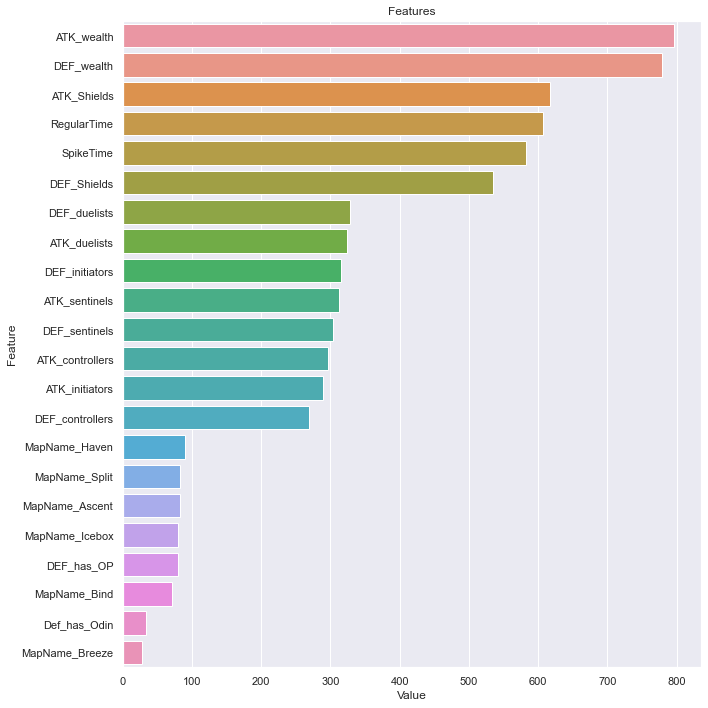

In [22]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
sns.set(font_scale = 1)
plt.title('Features')
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

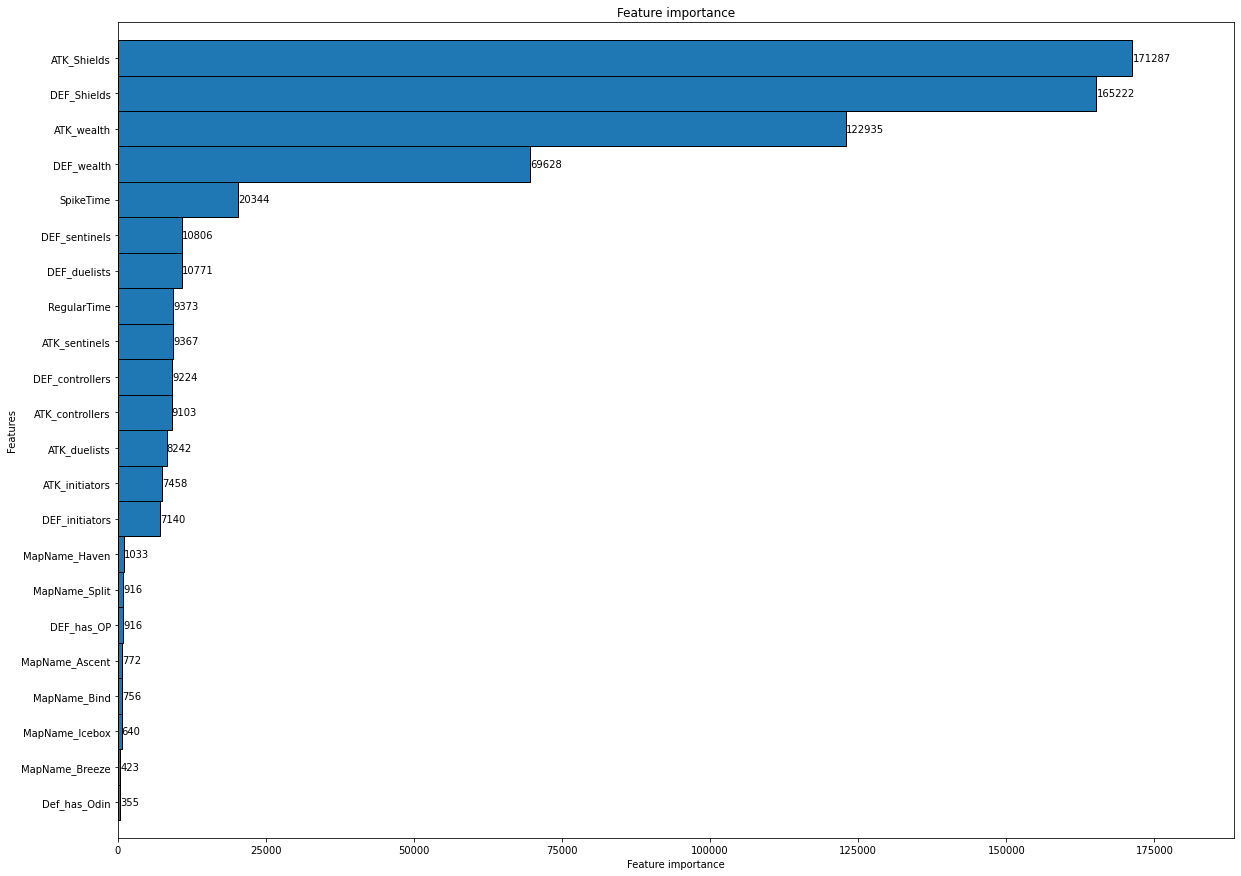

In [14]:
lightgbm.plot_importance(model, height=1, importance_type="gain", precision=0, grid=False, figsize=(20,15), edgecolor='black')

# <font color='blue'>MODEL PRECISION </font>

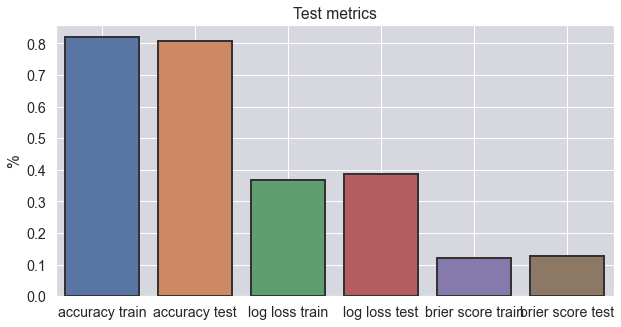

Wall time: 1.11 s


In [15]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]),brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [16]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.12739848030277962


# <font color='blue'>REALIBITY CURVE </font>

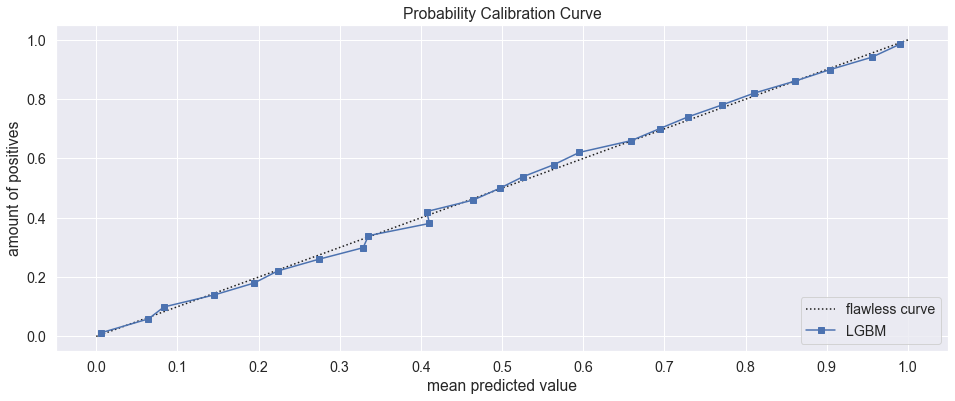

Wall time: 175 ms


Text(0.5, 0, 'mean predicted value')

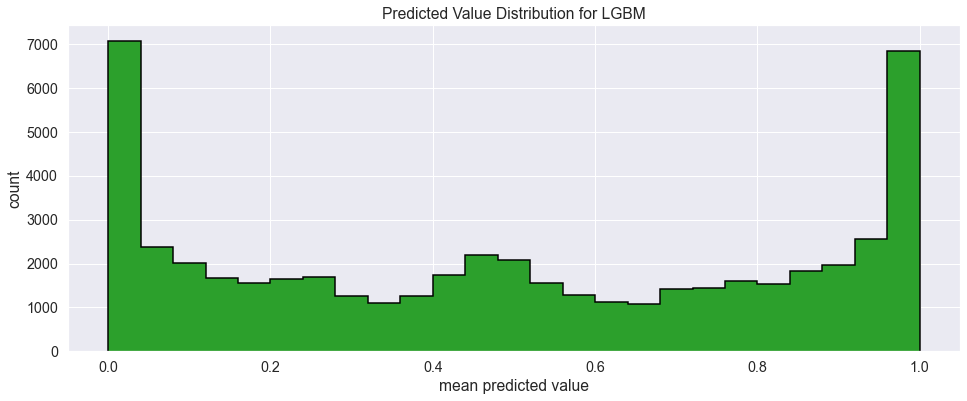

In [17]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

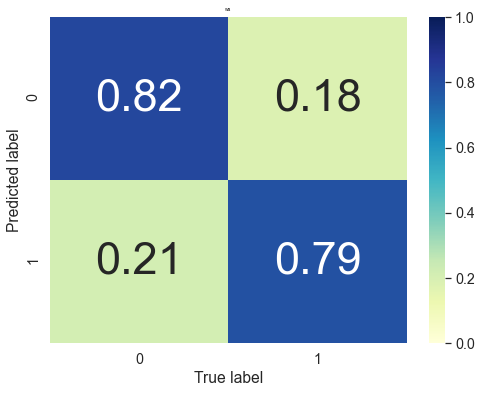

In [18]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [19]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8062763147493516